In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

from datetime import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt

import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import register_matplotlib_converters

import statsmodels.api as sm
from statsmodels.tsa.api import Holt

import acquire
import prepare

In [53]:
df = pd.read_csv('saas.csv')
df.columns = [col.lower() for col in df.columns]

In [54]:
df.index = pd.to_datetime(df.month_invoiced)
df = df.drop(columns=['month_invoiced'])

In [57]:
# split into train, validation, test
train = df.loc[:'2016-01-31']
validate = df.loc['2016-01-31':'2017-01-31']
test = df.loc['2017-01-31': ]

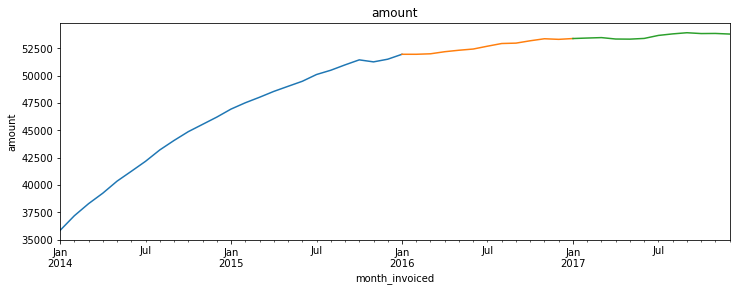

In [58]:
col = 'amount'
resample_by = 'M'
plt.figure(figsize=(12,4))
train.resample(resample_by).sum().amount.plot()
validate.resample(resample_by).sum().amount.plot()
test.resample(resample_by).sum().amount.plot()
plt.ylabel(col)
plt.title(col)
plt.show()


In [6]:
train = train.resample('M').sum()
validate = validate.resample('M').sum()
test = test.resample('M').sum()

In [7]:
# evaluation function to compute rmse
def evaluate(target_var):
    rmse = round(sqrt(mean_squared_error(validate[target_var], yhat_df[target_var])), 0)
    return rmse
# plot and evaluate 
def plot_and_eval(target_var):
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label = 'Train', linewidth = 1)
    plt.plot(validate[target_var], label = 'Validate', linewidth = 1)
    plt.plot(yhat_df[target_var], label = 'Predicted')
    plt.title(target_var)
    plt.legend()
    rmse = evaluate(target_var)
    print(target_var, '-- RMSE: {:.0f}'.format(rmse))
    plt.show()
    
# Create the empty dataframe
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])

# function to store rmse for comparison purposes
def append_eval_df(model_type, target_var):
    rmse = evaluate(target_var)
    d = {'model_type': [model_type], 'target_var': [target_var], 'rmse': [rmse]}
    d = pd.DataFrame(d)
    return eval_df.append(d, ignore_index = True)


In [8]:
amount = train.resample('M').amount.sum()[-1:][0]

yhat_df = pd.DataFrame({'amount': [amount]}, 
                       index = validate.index)

yhat_df.head(2)


,amount
month_invoiced,
2016-01-31,51955.0
2016-02-29,51955.0


amount -- RMSE: 897


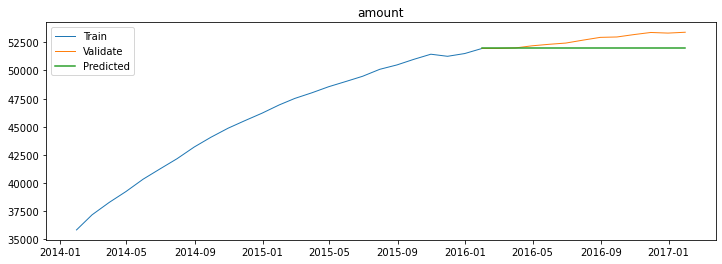

In [9]:
plot_and_eval('amount')

In [10]:
eval_df = append_eval_df(model_type='last_observed_value', target_var = 'amount')

In [11]:
eval_df

,model_type,target_var,rmse
0,last_observed_value,amount,897.0


Simple average

In [12]:
amount = train.resample('M').amount.sum().mean()

yhat_df = pd.DataFrame({'amount': [amount]}, 
                       index = validate.index)

yhat_df.head(2)

,amount
month_invoiced,
2016-01-31,45824.0
2016-02-29,45824.0


amount -- RMSE: 6870


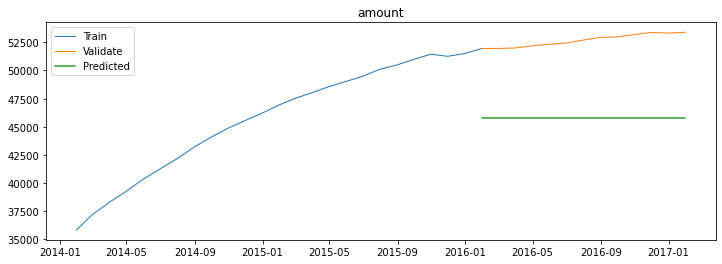

In [13]:
plot_and_eval('amount')

In [14]:
eval_df = append_eval_df(model_type='simple_average', 
                             target_var = col)

In [15]:
eval_df

,model_type,target_var,rmse
0,last_observed_value,amount,897.0
1,simple_average,amount,6870.0


In [16]:
# compute a 30 day rolling average, 
# use the most recent/last 30 day period value to predict forward. 

period = 10

amount = round(train.resample('M').amount.sum().rolling(period).mean().iloc[-1], 2)

# yhat_df = make_predictions()

yhat_df = pd.DataFrame({'amount': [amount],
                           }, index = validate.index)
yhat_df.head(2)

,amount
month_invoiced,
2016-01-31,50482.0
2016-02-29,50482.0


amount -- RMSE: 2256


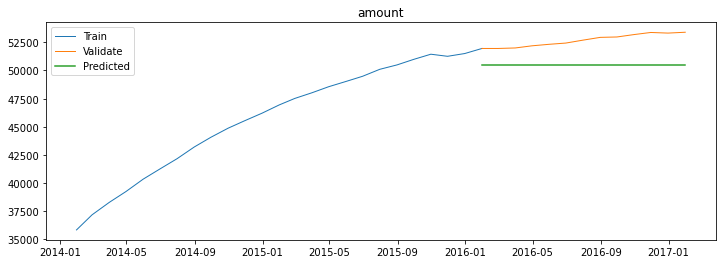

In [17]:
plot_and_eval('amount')

In [18]:
append_eval_df(model_type='10M moving average',target_var='amount')

,model_type,target_var,rmse
0,last_observed_value,amount,897.0
1,simple_average,amount,6870.0
2,10M moving average,amount,2256.0


In [19]:
periods = range(1,12)

for p in periods:
    

    amount = round(train.resample('M').amount.sum().rolling(p).mean().iloc[-1], 2)

    # yhat_df = make_predictions()

    yhat_df = pd.DataFrame({'amount': [amount],
                               }, index = validate.index)

    model_type = str(p) + 'M moving average'
    eval_df = append_eval_df(model_type = model_type,
                             target_var = 'amount'
                            )


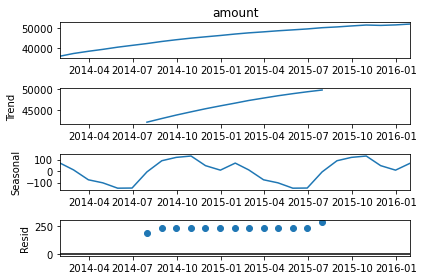

In [20]:
sm.tsa.seasonal_decompose(train.amount).plot()
None

In [21]:

model = Holt(train.amount, exponential = False, damped=True)
model = model.fit(optimized = True)
yhat_items = model.predict(start = validate.index[0], 
                           end = validate.index[-1])
yhat_df['amount'] = round(yhat_items, 2)


amount -- RMSE: 553


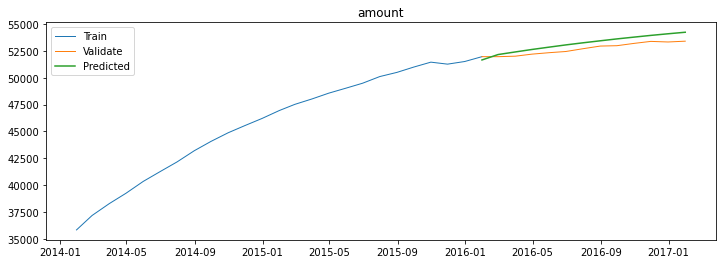

In [22]:
plot_and_eval('amount')

In [23]:
eval_df=append_eval_df(model_type='Holts', target_var='amount')

In [25]:
train_h = train
validate_h = validate
test_h = test

Use previous cycle

In [26]:
train = df[:'2015']
validate = df['2016']
test = df['2017']

In [27]:
train = train.resample('M').sum()
validate = validate.resample('M').sum()
test = test.resample('M').sum()

In [28]:
yhat_df = train['2015'] + train.diff(12).mean()

In [29]:
yhat_df

,customer_id,invoice_id,subscription_type,amount
month_invoiced,,,,
2015-01-31,1.610465e+10,8.715585e+10,11006.75,55033.75
2015-02-28,1.595642e+10,8.668951e+10,11121.75,55608.75
2015-03-31,1.580715e+10,8.621000e+10,11222.75,56113.75
2015-04-30,1.565336e+10,8.570140e+10,11329.75,56648.75
2015-05-31,1.550303e+10,8.520072e+10,11422.75,57113.75
2015-06-30,1.536759e+10,8.477223e+10,11514.75,57573.75
2015-07-31,1.523028e+10,8.432606e+10,11638.75,58193.75
2015-08-31,1.509680e+10,8.389434e+10,11716.75,58583.75
2015-09-30,1.495113e+10,8.339126e+10,11814.75,59073.75


In [30]:
pd.concat([yhat_df.head(1), validate.head(1)])

,customer_id,invoice_id,subscription_type,amount
month_invoiced,,,,
2015-01-31,1.610465e+10,8.715585e+10,11006.75,55033.75
2016-01-31,1.635248e+10,8.781191e+10,10391.00,51955.00


In [31]:
yhat_df.index = validate.index

In [32]:
yhat_df = pd.DataFrame(yhat_df)

amount -- RMSE: 5192


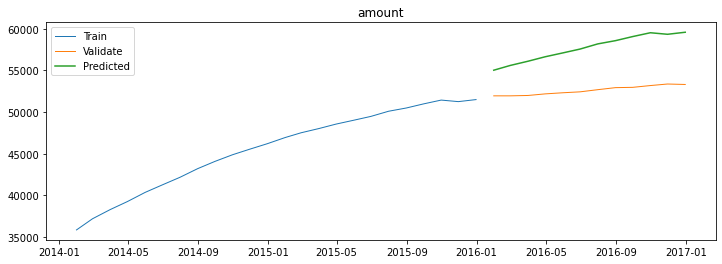

In [33]:
plot_and_eval('amount')
eval_df = append_eval_df(model_type='previous_year', target_var='amount')

In [34]:
# get the min rmse for each variable

min_rmse_amount = eval_df.groupby('target_var')['rmse'].min()[0]

# filter only the rows that match those rmse to find out 
# which models are best thus far
eval_df[((eval_df.rmse == min_rmse_amount)
        )]


,model_type,target_var,rmse
13,Holts,amount,553.0


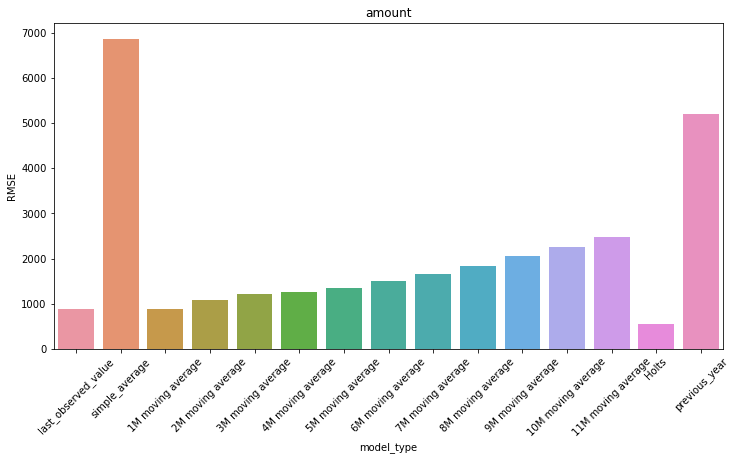

In [35]:
x = eval_df[eval_df.target_var == 'amount']['model_type']
y = eval_df[eval_df.target_var == 'amount']['rmse']
plt.figure(figsize=(12, 6))
sns.barplot(x, y)
plt.title(col)
plt.ylabel('RMSE')
plt.xticks(rotation=45)
plt.show()

## Predict using best model on TEST

In [39]:

model = Holt(train_h.amount, exponential = False, damped=True)
model = model.fit(optimized = True)
yhat_items = model.predict(start = validate_h.index[0], 
                           end = validate_h.index[-1])
yhat_df['amount'] = round(yhat_items, 2)



In [40]:
yhat_test = model.predict(start = test.index[0],
                          end = test.index[-1])

In [46]:
yhat_test_df = pd.DataFrame(yhat_test, columns = ['amount'])

TEST SET amount -- RMSE: 1262


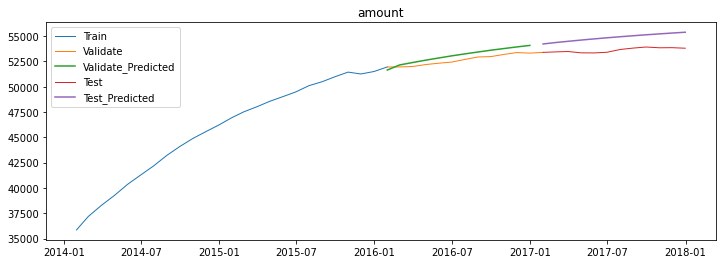

In [52]:
target_var = 'amount'
plt.figure(figsize = (12,4))
plt.plot(train_h[target_var], label = 'Train', linewidth = 1)
plt.plot(validate_h[target_var], label = 'Validate', linewidth = 1)
plt.plot(yhat_df[target_var], label = 'Validate_Predicted')
plt.plot(test_h[target_var], label = 'Test', linewidth = 1)
plt.plot(yhat_test_df[target_var], label = 'Test_Predicted')
plt.title(target_var)
plt.legend()
rmse = mean_squared_error(test_h[target_var],yhat_test_df[target_var], squared=False)
print('TEST SET',target_var, '-- RMSE: {:.0f}'.format(rmse))
plt.show()

## SVR Model

In [35]:
from sklearn import svm
from sklearn import metrics

In [36]:
store = acquire.acquire_all()
store = prepare.prepare_store(store)

In [37]:
store.index

DatetimeIndex(['2013-01-01', '2013-01-01', '2013-01-01', '2013-01-01',
               '2013-01-01', '2013-01-01', '2013-01-01', '2013-01-01',
               '2013-01-01', '2013-01-01',
               ...
               '2017-12-31', '2017-12-31', '2017-12-31', '2017-12-31',
               '2017-12-31', '2017-12-31', '2017-12-31', '2017-12-31',
               '2017-12-31', '2017-12-31'],
              dtype='datetime64[ns]', name='sale_date', length=913000, freq=None)

In [38]:
daily_df = store.quantity.resample('D').agg('mean')

In [39]:
train = np.array(daily_df[:'2016'])
test = np.array(daily_df['2017':])

In [40]:
def embed_data(x, steps):
    n = len(x)
    xout = np.zeros((n-steps, steps))
    yout = x[steps:]
    for i in np.arange(steps, n):
        xout[i-steps] = x[i-steps:i]
    return xout, yout


In [41]:
xtrain, ytrain = embed_data(train, 50)

In [42]:
xtest, ytest = embed_data(test, 50)

In [43]:
m = svm.SVR(gamma = 0.1)
m_fit = m.fit(xtrain,ytrain)

In [44]:
y_pred = m_fit.predict(xtrain)

In [45]:
mse = metrics.mean_squared_error(y_pred, ytrain, squared=False)

In [46]:
print(mse)

11.042692098498623


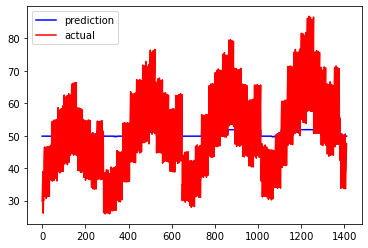

In [47]:
plt.plot(y_pred, 'b-', label = 'prediction')
plt.plot(ytrain, 'r-', label = 'actual')
plt.legend()

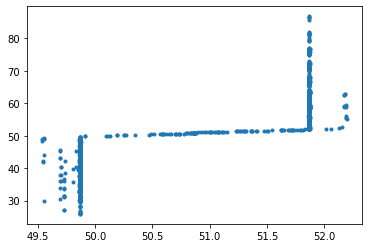

In [48]:
plt.plot(y_pred, ytrain, '.')

In [49]:
y_test_pred = m_fit.predict(xtest)

In [50]:
metrics.mean_squared_error(y_test_pred, ytest, squared=False)

15.839347691215357

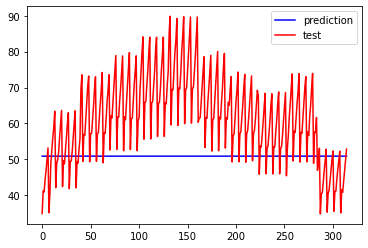

In [51]:
plt.plot(y_test_pred,'b-', label = 'prediction')
plt.plot(ytest, 'r-', label = 'test')
plt.legend()

## SARIMA

In [52]:
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
import itertools as it

In [53]:
train=store[:'2016'].quantity.resample('D').agg('mean')
test=store['2017':].quantity.resample('D').agg('mean')

In [54]:
p=d=q = range(0,2)

In [55]:
pdq = list(it.product(p,d,q))

In [56]:
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(it.product(p, d, q))]

In [57]:
seasonal_pdq

[(0, 0, 0, 12),
 (0, 0, 1, 12),
 (0, 1, 0, 12),
 (0, 1, 1, 12),
 (1, 0, 0, 12),
 (1, 0, 1, 12),
 (1, 1, 0, 12),
 (1, 1, 1, 12)]

In [58]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue


 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.36813D+00    |proj g|=  9.50351D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      0      1      0     0     0   9.504D-06   5.368D+00
  F =   5.3681347602096716     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:15687.689769332661
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variabl

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  3.61561D+00    |proj g|=  5.03450D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      9     13      1     0     0   8.610D-06   3.611D+00
  F =   3.6105703313221031     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:10554.086508123186
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.75416D+00    |proj g|=  1.18688D-04


 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      1     16      1     0     0   1.186D-04   3.754D+00
  F =   3.7541561103381920     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:10973.644154408197
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.68129D+00    |proj g|=  5.71329D-01

At iterate    5    f=  3.65110D+00    |proj g|=  1.94462D-02

At iterate   10    f=  3.63832D+00    |proj g|=  3.61908D-03

           * 

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.68932D+00    |proj g|=  1.58152D-01


 This problem is unconstrained.



At iterate    5    f=  3.61446D+00    |proj g|=  1.11808D-02

At iterate   10    f=  3.61053D+00    |proj g|=  1.85084D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     13     19      1     0     0   6.793D-06   3.611D+00
  F =   3.6105274075157259     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:10555.961084760951
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.06149D+00    |proj g|=  2.24171D-01


 This problem is unconstrained.



At iterate    5    f=  5.00081D+00    |proj g|=  9.16168D-02

At iterate   10    f=  4.99965D+00    |proj g|=  2.55114D-02

At iterate   15    f=  4.95670D+00    |proj g|=  3.61559D-01

At iterate   20    f=  4.80972D+00    |proj g|=  5.63605D-01

At iterate   25    f=  4.72222D+00    |proj g|=  2.94806D-01

At iterate   30    f=  4.72071D+00    |proj g|=  4.52440D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     30     51      1     0     0   4.524D-05   4.721D+00
  F =   4.7207098979728919     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:13797.91432187

 This problem is unconstrained.



At iterate    5    f=  4.87333D+00    |proj g|=  1.72284D-02

At iterate   10    f=  4.30077D+00    |proj g|=  4.22199D-01

At iterate   15    f=  4.16401D+00    |proj g|=  3.32157D-01

At iterate   20    f=  4.16052D+00    |proj g|=  4.49939D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     22     56      1     0     0   2.189D-05   4.161D+00
  F =   4.1605234115158272     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:12163.049408449246
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.57317D+00    |proj g|=  1.32042D-01

At iterate    5    f=  3.53718D+00    |proj g|=  2.52302D-02

At iterate   10    f=  3.53007D+00    |proj g|=  3.39245D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     15      1     0     0   3.600D-06   3.530D+00
  F =   3.5300734045911879     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:10320.874488215451
RUNNING THE L-

 This problem is unconstrained.



At iterate    5    f=  3.80015D+00    |proj g|=  1.54147D+00

At iterate   10    f=  3.61548D+00    |proj g|=  1.58322D-01

At iterate   15    f=  3.59528D+00    |proj g|=  2.93641D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     17     36      1     0     0   3.156D-06   3.595D+00
  F =   3.5952819061329873     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:10511.413729720589


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.83726D+00    |proj g|=  1.84929D-02

At iterate    5    f=  4.63722D+00    |proj g|=  5.11030D-01

At iterate   10    f=  3.92217D+00    |proj g|=  7.46901D-01

At iterate   15    f=  3.59008D+00    |proj g|=  1.44567D+00

At iterate   20    f=  3.56060D+00    |proj g|=  2.34410D-01

At iterate   25    f=  3.55754D+00    |proj g|=  4.28215D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     45      1     0     0   

 This problem is unconstrained.


At iterate    5    f=  3.58578D+00    |proj g|=  2.78178D-02

At iterate   10    f=  3.58431D+00    |proj g|=  3.81048D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     14      1     0     0   1.334D-07   3.584D+00
  F =   3.5843114166692662     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:10479.357959507595
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.58841D+00    |proj g|=  6.03293D-02


 This problem is unconstrained.



At iterate    5    f=  3.53035D+00    |proj g|=  4.04834D-02

At iterate   10    f=  3.49788D+00    |proj g|=  3.86132D-02

At iterate   15    f=  3.48974D+00    |proj g|=  6.25783D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     16     35      1     0     0   6.060D-06   3.490D+00
  F =   3.4897431790542019     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:10205.029569196378
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate   

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  3.54815D+00    |proj g|=  1.72876D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      8     11      1     0     0   5.379D-07   3.548D+00
  F =   3.5481456748629130     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:10371.681661949431
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.89204D+00    |proj g|=  7.28518D-04

           * * *

Tit   = total number of iterations
Tnf   = total number o

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.68779D+00    |proj g|=  2.18128D-01

At iterate    5    f=  3.62485D+00    |proj g|=  4.77001D-02

At iterate   10    f=  3.54894D+00    |proj g|=  1.10139D-01

At iterate   15    f=  3.53953D+00    |proj g|=  5.73514D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     16     25      1     0     0   1.173D-06   3.540D+00
  F =   3.5395273865762222     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0,

 This problem is unconstrained.
 This problem is unconstrained.


  ys=-3.897E-03  -gs= 6.652E-04 BFGS update SKIPPED

At iterate   10    f=  3.52299D+00    |proj g|=  4.62264D-01

At iterate   15    f=  3.43970D+00    |proj g|=  5.06497D-02

At iterate   20    f=  3.43839D+00    |proj g|=  2.75953D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     20     36      1     1     0   2.760D-06   3.438D+00
  F =   3.4383868002853673     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:10052.966230433844
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         

 This problem is unconstrained.
 This problem is unconstrained.


  ys=-5.018E-03  -gs= 7.634E-02 BFGS update SKIPPED

At iterate    5    f=  3.58902D+00    |proj g|=  3.35884D-02

At iterate   10    f=  3.54764D+00    |proj g|=  1.06655D-01

At iterate   15    f=  3.53953D+00    |proj g|=  4.43115D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     16     37      1     1     0   1.141D-06   3.540D+00
  F =   3.5395273286246556     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 1, 0)x(1, 1, 1, 12)12 - AIC:10348.498854241243
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         

 This problem is unconstrained.


ARIMA(0, 1, 1)x(0, 0, 0, 12)12 - AIC:9928.2114552271
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.45361D+00    |proj g|=  1.58762D-01


 This problem is unconstrained.



At iterate    5    f=  3.32701D+00    |proj g|=  7.33986D-02

At iterate   10    f=  3.31883D+00    |proj g|=  1.18438D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     12     20      1     0     0   3.433D-06   3.319D+00
  F =   3.3188252171146924     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 1, 1)x(0, 0, 1, 12)12 - AIC:9703.60728440913
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.87565D+00    |proj g|=  7.07316D-02



 This problem is unconstrained.


At iterate    5    f=  3.75698D+00    |proj g|=  9.59664D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      8     17      1     0     0   2.202D-04   3.751D+00
  F =   3.7513389863690287     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 1, 1)x(0, 1, 0, 12)12 - AIC:10965.412518170302
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.65320D+00    |proj g|=  2.23185D-01


 This problem is unconstrained.



At iterate    5    f=  3.57418D+00    |proj g|=  1.82204D-01

At iterate   10    f=  3.41412D+00    |proj g|=  8.56210D-01

At iterate   15    f=  3.36424D+00    |proj g|=  8.69241D-02

At iterate   20    f=  3.36353D+00    |proj g|=  2.27880D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     20     30      1     0     0   2.279D-05   3.364D+00
  F =   3.3635261097123212     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 1, 1)x(0, 1, 1, 12)12 - AIC:9834.223292579403
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0

 This problem is unconstrained.



At iterate    5    f=  3.37625D+00    |proj g|=  2.20093D-02

At iterate   10    f=  3.36741D+00    |proj g|=  8.68273D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     12     15      1     0     0   1.867D-06   3.367D+00
  F =   3.3674115106435329     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 1, 1)x(1, 0, 0, 12)12 - AIC:9845.576434100403
RUNNING THE L-BFGS-B CODE

           * * *



 This problem is unconstrained.


Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.45362D+00    |proj g|=  1.58754D-01

At iterate    5    f=  3.31436D+00    |proj g|=  1.35467D-01

At iterate   10    f=  3.29095D+00    |proj g|=  3.22840D-02

At iterate   15    f=  3.27276D+00    |proj g|=  1.34553D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     26      1     0     0   6.895D-06   3.273D+00
  F =   3.2727151126358147     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 1, 1)x(1, 0, 1, 12)12 - AIC:9570.87355912185

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.75780D+00    |proj g|=  5.13345D-02

At iterate    5    f=  3.68010D+00    |proj g|=  2.29111D-02

At iterate   10    f=  3.65761D+00    |proj g|=  2.02402D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     14     24      1     0     0   1.805D-07   3.658D+00
  F =   3.6575258806482753     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 1, 1)x(1, 1, 0, 12)12 - AIC:10693.290623254261
RUNNING THE L-

 This problem is unconstrained.



At iterate    5    f=  3.54487D+00    |proj g|=  1.02351D-01

At iterate   10    f=  3.51147D+00    |proj g|=  1.55169D-01

At iterate   15    f=  3.36143D+00    |proj g|=  2.16253D-01

At iterate   20    f=  3.35801D+00    |proj g|=  1.04595D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     34      1     0     0   1.285D-06   3.358D+00
  F =   3.3580126604908282     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 1, 1)x(1, 1, 1, 12)12 - AIC:9820.1129939542
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0  

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f=  3.54982D+00    |proj g|=  1.00121D-01

At iterate   10    f=  3.54750D+00    |proj g|=  6.88522D-04

At iterate   15    f=  3.54750D+00    |proj g|=  8.03205D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     15     18      1     0     0   8.032D-05   3.547D+00
  F =   3.5474984037501911     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 0, 0)x(0, 0, 1, 12)12 - AIC:10371.790335758058
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate   

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  3.50419D+00    |proj g|=  3.08753D-02

At iterate   10    f=  3.47370D+00    |proj g|=  3.41479D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     12     21      1     0     0   1.590D-05   3.474D+00
  F =   3.4737037652834375     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 0, 0)x(0, 1, 1, 12)12 - AIC:10156.162402158205
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.02098D+00    |proj g|=  9.70933D-01

At iterate   

 This problem is unconstrained.



At iterate   10    f=  3.54845D+00    |proj g|=  1.58122D-02

At iterate   15    f=  3.54750D+00    |proj g|=  5.97420D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     15     24      1     0     0   5.974D-06   3.548D+00
  F =   3.5475027814190687     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 0, 0)x(1, 0, 0, 12)12 - AIC:10371.803127306519
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.84219D+00    |proj g|=  7.87381D-01


 This problem is unconstrained.



At iterate    5    f=  3.48938D+00    |proj g|=  4.19878D+00

At iterate   10    f=  3.48273D+00    |proj g|=  2.89196D+00

At iterate   15    f=  3.45520D+00    |proj g|=  1.79011D-01

At iterate   20    f=  3.45363D+00    |proj g|=  3.91358D-01

At iterate   25    f=  3.44116D+00    |proj g|=  3.02194D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     28     44      1     0     0   3.152D-04   3.441D+00
  F =   3.4410678901463165     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 0, 0)x(1, 0, 1, 12)12 - AIC:10062.800375007537
RUNNING THE L-BFGS-B CODE

           * * *

Machine prec

 This problem is unconstrained.



At iterate    5    f=  3.59149D+00    |proj g|=  1.38309D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      7     11      1     0     0   2.361D-07   3.591D+00
  F =   3.5914840199366354     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 0, 0)x(1, 1, 0, 12)12 - AIC:10500.316306254848
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.61591D+00    |proj g|=  1.73479D-01


 This problem is unconstrained.



At iterate    5    f=  3.50285D+00    |proj g|=  1.60122D-01

At iterate   10    f=  3.49511D+00    |proj g|=  3.12765D-02

At iterate   15    f=  3.47191D+00    |proj g|=  4.68930D-02

At iterate   20    f=  3.46988D+00    |proj g|=  3.50456D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     35      1     0     0   9.192D-05   3.470D+00
  F =   3.4698833928669655     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 0, 0)x(1, 1, 1, 12)12 - AIC:10146.999273957274
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X

 This problem is unconstrained.



At iterate   10    f=  3.40899D+00    |proj g|=  2.72127D-01

At iterate   15    f=  3.40611D+00    |proj g|=  2.23948D+00

At iterate   20    f=  3.39856D+00    |proj g|=  5.94936D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     22     31      1     0     0   2.301D-03   3.399D+00
  F =   3.3985605671702808     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 0, 1)x(0, 0, 0, 12)12 - AIC:9936.593977271561
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    

 This problem is unconstrained.



At iterate    5    f=  3.41813D+00    |proj g|=  2.20849D+00

At iterate   10    f=  3.36330D+00    |proj g|=  3.48477D-01

At iterate   15    f=  3.34483D+00    |proj g|=  3.23344D+00

At iterate   20    f=  3.34382D+00    |proj g|=  3.34724D-02

At iterate   25    f=  3.33743D+00    |proj g|=  7.54577D+00

At iterate   30    f=  3.32282D+00    |proj g|=  4.60596D-02

At iterate   35    f=  3.32104D+00    |proj g|=  3.59360D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     38     65      1     0     0   6.095D-03   3.321D+00
  F =   3.3210327373175055     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f=  3.56928D+00    |proj g|=  2.70649D-01

At iterate   10    f=  3.55816D+00    |proj g|=  4.00182D-01

At iterate   15    f=  3.55046D+00    |proj g|=  8.05545D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     18     37      1     0     0   2.663D-06   3.550D+00
  F =   3.5504505301686526     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 0, 1)x(0, 1, 0, 12)12 - AIC:10380.416449152803
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate   

 This problem is unconstrained.



At iterate    5    f=  3.46990D+00    |proj g|=  1.15573D-01

At iterate   10    f=  3.40011D+00    |proj g|=  1.13748D+00

At iterate   15    f=  3.38504D+00    |proj g|=  3.84952D-02

At iterate   20    f=  3.36475D+00    |proj g|=  2.13752D-01

At iterate   25    f=  3.36398D+00    |proj g|=  2.17502D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     48      1     0     0   2.175D-05   3.364D+00
  F =   3.3639829788582225     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 0, 1)x(0, 1, 1, 12)12 - AIC:9837.558264223726
RUNNING THE L-BFGS-B CODE

           * * *

Machine preci

 This problem is unconstrained.



At iterate    5    f=  3.59868D+00    |proj g|=  1.03847D+00

At iterate   10    f=  3.45336D+00    |proj g|=  7.84346D-01

At iterate   15    f=  3.39260D+00    |proj g|=  8.58841D-02

At iterate   20    f=  3.38918D+00    |proj g|=  1.19719D+00

At iterate   25    f=  3.36815D+00    |proj g|=  1.84204D+00

At iterate   30    f=  3.36741D+00    |proj g|=  1.82410D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     33     49      1     0     0   1.677D-06   3.367D+00
  F =   3.3674116858014886     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 0, 1)x(1, 0, 0, 12)12 - AIC:9847.576945911

 This problem is unconstrained.



At iterate    5    f=  3.43525D+00    |proj g|=  1.52714D+00

At iterate   10    f=  3.35170D+00    |proj g|=  6.46605D-01

At iterate   15    f=  3.32127D+00    |proj g|=  7.90754D+00

At iterate   20    f=  3.31185D+00    |proj g|=  1.40712D-01

At iterate   25    f=  3.30743D+00    |proj g|=  1.34911D+00

At iterate   30    f=  3.30675D+00    |proj g|=  4.17228D-01

At iterate   35    f=  3.28226D+00    |proj g|=  3.32517D+00

At iterate   40    f=  3.27478D+00    |proj g|=  5.96818D-02

At iterate   45    f=  3.27474D+00    |proj g|=  1.95870D-02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     49    109      2     0     0   1.715D-04   3.275D+00
  F =   3.2747393769706488     

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


ARIMA(1, 0, 1)x(1, 0, 1, 12)12 - AIC:9578.788459508236
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.58951D+00    |proj g|=  8.45616D-02


 This problem is unconstrained.



At iterate    5    f=  3.58438D+00    |proj g|=  1.61835D-02

At iterate   10    f=  3.58085D+00    |proj g|=  9.61321D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     14     16      1     0     0   1.718D-06   3.581D+00
  F =   3.5808053890192517     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 0, 1)x(1, 1, 0, 12)12 - AIC:10471.113346714254
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.58850D+00    |proj g|=  3.41469D-02


 This problem is unconstrained.



At iterate    5    f=  3.50549D+00    |proj g|=  8.86241D-02
  ys=-3.112E-03  -gs= 1.596E-02 BFGS update SKIPPED

At iterate   10    f=  3.46589D+00    |proj g|=  1.41299D-01

At iterate   15    f=  3.44545D+00    |proj g|=  1.20531D-01

At iterate   20    f=  3.43312D+00    |proj g|=  1.63226D-01

At iterate   25    f=  3.43093D+00    |proj g|=  5.23480D-02

At iterate   30    f=  3.43052D+00    |proj g|=  1.59449D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     31     56      1     1     0   1.244D-04   3.431D+00
  F =   3.4305248976889566     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  3.34684D+00    |proj g|=  2.96195D-02

At iterate   10    f=  3.32987D+00    |proj g|=  5.33326D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     20      1     0     0   1.962D-05   3.330D+00
  F =   3.3298691621649077     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 1, 0)x(0, 0, 1, 12)12 - AIC:9735.87769184586
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.88769D+00    |proj g|=  5.00235D-06

           * * 

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  3.59315D+00    |proj g|=  4.28586D-02

At iterate   10    f=  3.48363D+00    |proj g|=  9.00706D-02

At iterate   15    f=  3.48049D+00    |proj g|=  2.39169D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     15     22      1     0     0   2.392D-06   3.480D+00
  F =   3.4804943891034674     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 1, 0)x(0, 1, 1, 12)12 - AIC:10176.004604960332
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate   

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      9     11      1     0     0   1.004D-06   3.465D+00
  F =   3.4649495146017757     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 1, 0)x(1, 0, 0, 12)12 - AIC:10130.582481666388
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.48427D+00    |proj g|=  1.73501D-01


 This problem is unconstrained.



At iterate    5    f=  3.38059D+00    |proj g|=  2.27402D-01

At iterate   10    f=  3.33927D+00    |proj g|=  5.09658D-02

At iterate   15    f=  3.32220D+00    |proj g|=  9.34370D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     18     23      1     0     0   2.181D-06   3.322D+00
  F =   3.3221971581847338     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 1, 0)x(1, 0, 1, 12)12 - AIC:9715.460096215793
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    

 This problem is unconstrained.



At iterate   10    f=  3.74927D+00    |proj g|=  4.36451D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     10     12      1     0     0   4.365D-07   3.749D+00
  F =   3.7492659983464320     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 1, 0)x(1, 1, 0, 12)12 - AIC:10961.355247168274
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.74406D+00    |proj g|=  1.73842D-01


 This problem is unconstrained.



At iterate    5    f=  3.58404D+00    |proj g|=  4.46193D-02

At iterate   10    f=  3.52797D+00    |proj g|=  2.54871D-01

At iterate   15    f=  3.45980D+00    |proj g|=  1.76529D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     30      1     0     0   1.156D-05   3.460D+00
  F =   3.4597947727416782     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 1, 0)x(1, 1, 1, 12)12 - AIC:10117.520325951184
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate   

 This problem is unconstrained.



At iterate   10    f=  3.37624D+00    |proj g|=  6.03334D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     14     19      1     0     0   5.811D-07   3.376D+00
  F =   3.3759675718007132     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 1, 1)x(0, 0, 0, 12)12 - AIC:9870.577244801683
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.43282D+00    |proj g|=  2.51716D-01


 This problem is unconstrained.



At iterate    5    f=  3.35323D+00    |proj g|=  3.21690D-02

At iterate   10    f=  3.32118D+00    |proj g|=  1.16773D-01

At iterate   15    f=  3.31595D+00    |proj g|=  3.16056D-02

At iterate   20    f=  3.31546D+00    |proj g|=  1.11284D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     27      1     0     0   1.113D-06   3.315D+00
  F =   3.3154621072587638     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 1, 1)x(0, 0, 1, 12)12 - AIC:9695.780277410107
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0

 This problem is unconstrained.



At iterate    5    f=  3.72960D+00    |proj g|=  3.58005D-01

At iterate   10    f=  3.72050D+00    |proj g|=  2.43173D-02

At iterate   15    f=  3.70726D+00    |proj g|=  9.96162D-02

At iterate   20    f=  3.69334D+00    |proj g|=  1.13399D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     21     31      1     0     0   3.310D-07   3.693D+00
  F =   3.6933407075013118     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 1, 1)x(0, 1, 0, 12)12 - AIC:10797.941547318833
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X

 This problem is unconstrained.



At iterate    5    f=  3.52281D+00    |proj g|=  1.53711D-01

At iterate   10    f=  3.43478D+00    |proj g|=  4.19555D-01

At iterate   15    f=  3.34373D+00    |proj g|=  5.38010D-02

At iterate   20    f=  3.34358D+00    |proj g|=  4.56417D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     28      1     0     0   4.564D-06   3.344D+00
  F =   3.3435830210649384     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 1, 1)x(0, 1, 1, 12)12 - AIC:9777.94958755175
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0 

 This problem is unconstrained.



At iterate    5    f=  3.36218D+00    |proj g|=  2.45565D-02

At iterate   10    f=  3.35166D+00    |proj g|=  4.34441D-02

At iterate   15    f=  3.35063D+00    |proj g|=  6.10303D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     15     18      1     0     0   6.103D-06   3.351D+00
  F =   3.3506292103911850     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 1, 1)x(1, 0, 0, 12)12 - AIC:9798.538552763042
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    

 This problem is unconstrained.



At iterate    5    f=  3.34973D+00    |proj g|=  1.10188D-01

At iterate   10    f=  3.31550D+00    |proj g|=  2.43436D-01

At iterate   15    f=  3.27271D+00    |proj g|=  3.22972D-02

At iterate   20    f=  3.26648D+00    |proj g|=  3.64841D-02

At iterate   25    f=  3.26583D+00    |proj g|=  5.31251D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     26     41      1     0     0   7.689D-06   3.266D+00
  F =   3.2658337824457426     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 1, 1)x(1, 0, 1, 12)12 - AIC:9552.76631230646
RUNNING THE L-BFGS-B CODE

           * * *

Machine precis

 This problem is unconstrained.



At iterate    5    f=  3.64685D+00    |proj g|=  1.81964D-01

At iterate   10    f=  3.63224D+00    |proj g|=  9.79822D-02

At iterate   15    f=  3.58944D+00    |proj g|=  2.56540D-02

At iterate   20    f=  3.58941D+00    |proj g|=  1.61280D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     25      1     0     0   1.613D-06   3.589D+00
  F =   3.5894111115044067     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(1, 1, 1)x(1, 1, 0, 12)12 - AIC:10496.259267815876
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X

 This problem is unconstrained.



At iterate    5    f=  3.53745D+00    |proj g|=  1.10339D-01

At iterate   10    f=  3.51287D+00    |proj g|=  9.98830D-02

At iterate   15    f=  3.35054D+00    |proj g|=  2.57777D-01

At iterate   20    f=  3.34379D+00    |proj g|=  3.16763D-04



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     23     55      1     0     0   2.900D-05   3.344D+00
  F =   3.3437884783655876     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 1, 1)x(1, 1, 1, 12)12 - AIC:9780.549933784247


In [59]:
yhat['sarimax'] = mod.predict(start='20170101', end='20171231', dynamic=True)
yhat.head()


TypeError: predict() missing 1 required positional argument: 'params'